In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from matplotlib.pyplot import cm 
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import cm 
data = pd.read_csv("carsdata_features.csv", engine='c')

## Prépartion des données

les modèles de voitures sont disponible dans plusieur colones. On va les rassembler dans une matice finale sous une forme `one hot encoding`.

In [2]:
car_classes = ["bus","cabriolet","coupe","hatchback","mpv","pickup","sedan","stationwagon","suv_crossover"]
car_classes.sort()

In [3]:
raw_target = data.loc[:,car_classes]
target = raw_target.as_matrix().astype('float32')

In [4]:
cat_class = [np.argmax(x) for x in target]

## Sélection des données

In [5]:
excluded_cols = ["marque","modele","version","date_fin","date_sortie"]
excluded_cols = excluded_cols + car_classes
selected_data = data.loc[:, ~ data.columns.isin(excluded_cols)]

In [6]:
# séparation des variables binaires et continues 
cont_data = selected_data.loc[:,selected_data.apply(max) > 1.0]
bin_data = selected_data.loc[:, selected_data.apply(max) <= 1.0]

## Correction des valeurs manquantes

In [7]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(cont_data.as_matrix().astype('float32'))

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [8]:
cont_mat = imp.transform(cont_data.as_matrix().astype('float32'))

In [9]:
bin_data.replace(to_replace=0, value=-1, inplace=True)

c:\users\michael\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
bin_mat = bin_data.as_matrix().astype('float32')

## Standardisation

In [11]:
from sklearn.preprocessing import scale
scaled_cont_mat = scale(cont_mat)

c:\users\michael\anaconda\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
c:\users\michael\anaconda\lib\site-packages\sklearn\preprocessing\data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


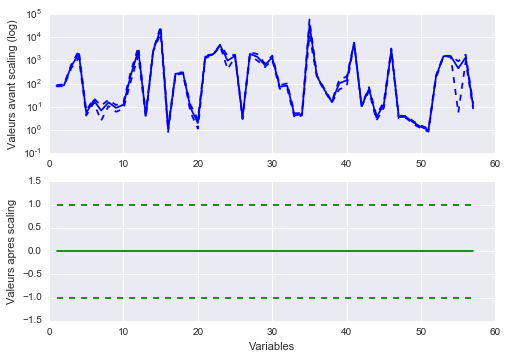

In [12]:
avant_scaling = stats.describe(cont_mat)
apres_scaling = stats.describe(scaled_cont_mat)
elements = range(1, len(avant_scaling.variance) + 1)

plt.subplot(211)
plt.plot(elements, avant_scaling.mean - np.sqrt(avant_scaling.variance), '--', color='blue')
plt.plot(elements, avant_scaling.mean + np.sqrt(avant_scaling.variance), '--', color='blue')
plt.plot(elements, avant_scaling.mean , '-', label="Avant scaling", color='blue')
plt.yscale('log')
plt.ylabel('Valeurs avant scaling (log)')

plt.subplot(212)
plt.plot(elements, apres_scaling.mean - np.sqrt(apres_scaling.variance), '--', color='green')
plt.plot(elements, apres_scaling.mean + np.sqrt(apres_scaling.variance), '--', color='green')
plt.plot(elements, apres_scaling.mean , '-', label="Apres scaling", color='green')
plt.ylabel('Valeurs apres scaling')
plt.xlabel('Variables')

plt.show()

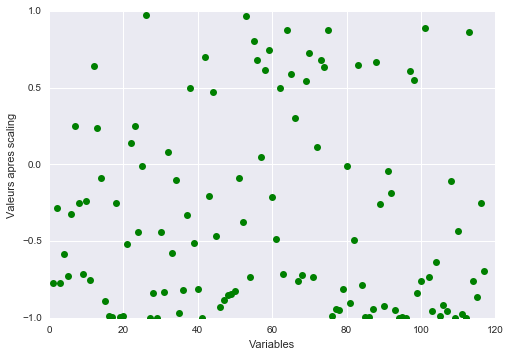

In [13]:
var_cat = stats.describe(bin_mat)
elements = range(1, len(var_cat.variance) + 1)

plt.plot(elements, var_cat.mean , 'o', label="Apres scaling", color='green')
plt.ylabel('Valeurs apres scaling')
plt.xlabel('Variables')

plt.show()

## Assemblage de la matrice

In [14]:
mat = np.hstack((bin_mat, cont_mat))


## Echantillonage stratifié

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

In [16]:
#Test set
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2)
for train_index, test_index in sss.split(mat,target):
    X_train, X_test = mat[train_index], mat[test_index]
    y_train, y_test = target[train_index], target[test_index]

In [17]:
#validation set
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
for train_index, test_index in sss2.split(X_train, y_train):
    partial_X_train, X_val = X_train[train_index], X_train[test_index]
    partial_y_train, y_val = y_train[train_index], y_train[test_index]

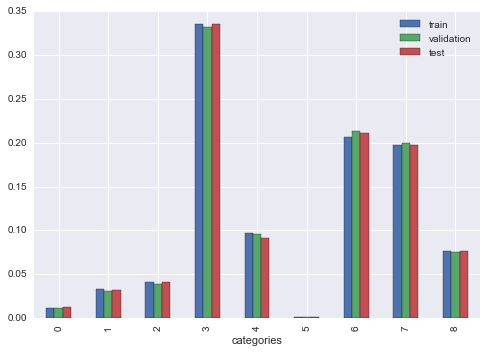

In [18]:
#Evaluation de l'échantillonage
categories = np.arange(9)
df = pd.DataFrame()
df['categories'] = categories
df['train'] =  partial_y_train.sum(axis=0)/partial_y_train.sum()
df['validation'] = y_val.sum(axis=0)/y_val.sum()
df['test'] = y_test.sum(axis=0)/y_test.sum()
df.plot(x="categories",y=["train","validation","test"], kind="bar")
plt.show()

## Classification

In [19]:
from sklearn.linear_model import LogisticRegression as LR

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [21]:
#encode the target
cat_train = [np.argmax(x) for x in y_train]

In [22]:
cat_test = [np.argmax(x) for x in y_test]

In [23]:
lr = LR(C=1e-5, class_weight='balanced', n_jobs=-1, solver='sag', multi_class='multinomial', max_iter=500, fit_intercept=False)
lr.fit(X_train, cat_train)

c:\users\michael\anaconda\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1e-05, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=500,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)

In [24]:
print(classification_report(cat_test, lr.predict(X_test)))

             precision    recall  f1-score   support

          0       0.32      0.41      0.36       317
          1       0.50      0.72      0.59       389
          2       0.26      0.52      0.34       464
          3       0.81      0.74      0.77      4200
          4       0.69      0.78      0.73      1242
          5       0.32      1.00      0.48         7
          6       0.73      0.60      0.66      2719
          7       0.66      0.64      0.65      2550
          8       0.71      0.73      0.72      1023

avg / total       0.70      0.68      0.68     12911



## Cross validation

In [25]:
from sklearn.model_selection import GridSearchCV


In [26]:
# Set the parameters by cross-validation
tuned_parameters = [{'C': [1, 1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]} ]

In [27]:
clf = GridSearchCV(LR(class_weight='balanced', 
                      n_jobs=-1, solver='sag', 
                      multi_class='multinomial', 
                      max_iter=500, 
                      fit_intercept=False), tuned_parameters, cv=5, scoring='f1_macro')

In [28]:
clf.fit(X_train, cat_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=500,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_macro', verbose=0)

In [29]:
print(clf.best_params_)

{'C': 0.001}


In [30]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

In [31]:
means

array([ 0.59834803,  0.59838356,  0.59823634,  0.59855476,  0.59834341,
        0.59850968,  0.5984596 ])

In [32]:
stds

array([ 0.01725754,  0.01724519,  0.01735322,  0.01699944,  0.01732019,
        0.01714086,  0.01709882])

In [33]:
print(classification_report(cat_test, clf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.32      0.41      0.36       317
          1       0.50      0.72      0.59       389
          2       0.26      0.52      0.34       464
          3       0.81      0.74      0.77      4200
          4       0.69      0.78      0.73      1242
          5       0.32      1.00      0.48         7
          6       0.73      0.60      0.66      2719
          7       0.66      0.64      0.65      2550
          8       0.71      0.73      0.72      1023

avg / total       0.70      0.68      0.68     12911



## PCA

In [34]:
from sklearn.decomposition import PCA

In [35]:
pca = PCA(svd_solver='full', n_components='mle')

In [36]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [37]:
pca.n_components_

173

In [38]:
X_train.shape

(51642L, 174L)

In [39]:
pca.explained_variance_ratio_

array([  8.93363253e-01,   1.02424119e-01,   1.86935245e-03,
         6.67696285e-04,   5.20821667e-04,   2.93814491e-04,
         2.56589212e-04,   1.96967491e-04,   1.45668102e-04,
         1.05651340e-04,   5.11991820e-05,   3.46226612e-05,
         2.94363199e-05,   1.00309323e-05,   9.90289071e-06,
         6.74236656e-06,   5.43640929e-06,   3.36333357e-06,
         1.43920609e-06,   1.08822724e-06,   6.60481894e-07,
         4.69600837e-07,   3.95336191e-07,   2.74770342e-07,
         2.03959848e-07,   1.90662684e-07,   1.54522344e-07,
         1.16144378e-07,   6.24217332e-08,   5.32679069e-08,
         3.79586671e-08,   2.98821698e-08,   2.96898279e-08,
         1.92582089e-08,   1.19112497e-08,   1.03404204e-08,
         1.01327007e-08,   6.14509538e-09,   3.96727197e-09,
         3.09146548e-09,   2.40680912e-09,   2.23328996e-09,
         1.87988177e-09,   1.75563019e-09,   1.64133218e-09,
         1.59798554e-09,   1.51100478e-09,   1.49688545e-09,
         1.42975328e-09,

In [40]:
pca2 = PCA(svd_solver='full', n_components=2)

In [41]:
train_pca = pca2.fit_transform(X_train)

In [42]:
pca2.explained_variance_ratio_

array([ 0.89336325,  0.10242412])

In [43]:
sum(pca2.explained_variance_ratio_)

0.99578737250359617

In [44]:
test_pca = pca2.transform(X_test)

In [45]:
train_pca[:5]

array([[ -4168.24011932,  -1788.00167484],
       [ -9919.35779594,    677.20924448],
       [-11025.23028091,   8579.38583677],
       [-10743.49451243,  -6379.20860125],
       [ 19587.64675655,   6741.7721419 ]])

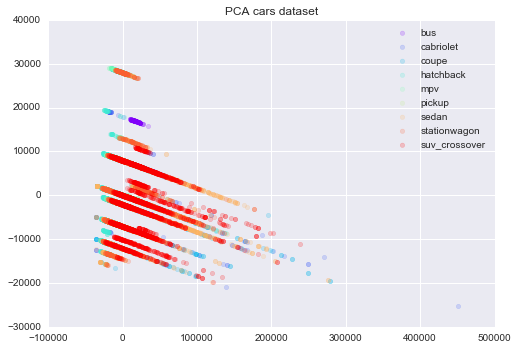

In [46]:
plt.figure()
colors = iter(cm.rainbow(np.linspace(0,1,9)))
lw = .5

X_r = train_pca
y = np.array(cat_train)

for i, target_name in enumerate(car_classes):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=next(colors), alpha=.2, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA cars dataset')

plt.show()

## Clustering

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
X_train.shape

(51642L, 174L)

In [28]:
train_labels = np.array(cat_train)
train_labels.shape

(51642L,)

In [50]:
# sorting based on the labels
p = np.argsort(train_labels)

In [51]:
sorted_X_train = X_train[p]

In [52]:
sim_mat = cosine_similarity(sorted_X_train)

In [53]:
sim_mat.shape

(51642L, 51642L)

In [67]:
mean_sim_mat = np.zeros([9,9])

In [111]:
for i in range(9):
    rows = (train_labels[p] == i)
    
    for j in range(9):
        cols = (train_labels[p] == j)

        mean_sim_mat[i,j] = np.mean(sim_mat[np.ix_(rows,cols)])
    


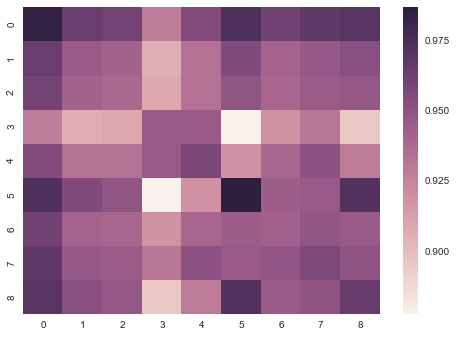

In [114]:
sns.heatmap(mean_sim_mat)
plt.show()

## Feature selection

In [24]:
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LogisticRegressionCV

In [62]:
select = SelectKBest(k=10).fit(X_train, train_labels)

In [63]:
X_new = select.transform(X_train)

In [64]:
X_test_new = select.transform(X_test)

In [70]:
lr = LR(C=0.001, class_weight='balanced', n_jobs=-1, solver='sag', multi_class='multinomial', fit_intercept=False)
lr.fit(X_new, cat_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)

In [71]:
print(classification_report(cat_test, lr.predict(X_test_new)))

             precision    recall  f1-score   support

          0       1.00      0.03      0.06       361
          1       0.24      0.71      0.36       413
          2       0.16      0.50      0.24       523
          3       0.87      0.19      0.31      4270
          4       0.44      0.88      0.59      1164
          5       0.09      0.89      0.16        18
          6       0.41      0.08      0.13      2678
          7       0.30      0.66      0.41      2508
          8       0.65      0.35      0.45       976

avg / total       0.56      0.36      0.32     12911



In [72]:
lrcv = LogisticRegressionCV(scoring='f1_macro',class_weight='balanced', n_jobs=-1, solver='sag', multi_class='multinomial', fit_intercept=False)

In [73]:
lrcv.fit(X_new, cat_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=None, dual=False,
           fit_intercept=False, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='f1_macro', solver='sag',
           tol=0.0001, verbose=0)

In [77]:
lrcv.score(X_test_new, cat_test)

0.40577801874370689

In [79]:
scores =[]
for i in range(5,170,5):
    select = SelectKBest(k=i).fit(X_train, train_labels)
    X_new = select.transform(X_train)
    X_test_new = select.transform(X_test)
    lrcv.fit(X_new, cat_train)
    scores.append(lrcv.score(X_test_new, cat_test))

c:\users\michael\anaconda\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


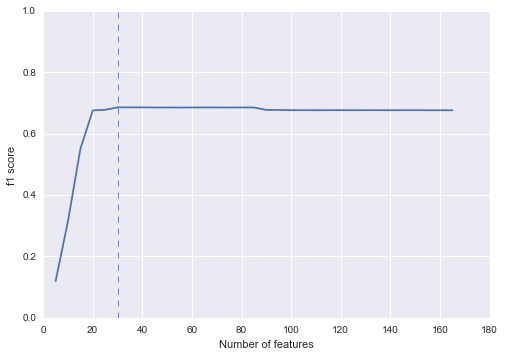

In [92]:
plt.plot(range(5,170,5), scores)
plt.xlabel('Number of features')
plt.ylabel('f1 score')
plt.axvline(30,lw=0.5).set_linestyle('--')
plt.ylim(0,1)
plt.show()